# Locations of Suvivor US seasons
> Make a geocoded list of season locations and sketch them on a map.   

#### Load Python tools and Jupyter config

In [1]:
import os
import googlemaps
import pandas as pd
import altair as alt
import geopandas as gpd
from IPython.display import Image
from shapely.geometry import Point, mapping

In [2]:
google_key = os.environ.get("GOOGLE_GEOCODER")

---

## Read, process data

#### Season summary dataframe from the [`survivoR`](https://github.com/doehm/survivoR) package and converted to CSV

In [3]:
src = pd.read_csv(
    "../data/raw/csv/season_summary.csv",
    dtype={"season": int},
)

#### Just the US and only columns we need

In [4]:
df = src.query('version=="US"')[["season_name", "season", "location", "country"]]

#### Geocode locations

In [5]:
# Initialize the Google Maps client
gmaps = googlemaps.Client(key=google_key)


# Function to geocode a location
def geocode_location(location, country):
    try:
        # Geocode the location
        geocode_result = gmaps.geocode(f"{location}, {country}")
        if geocode_result:
            lat = geocode_result[0]["geometry"]["location"]["lat"]
            lng = geocode_result[0]["geometry"]["location"]["lng"]
            return pd.Series([lat, lng])
        else:
            return pd.Series([None, None])
    except Exception as e:
        print(f"Error geocoding {location}, {country}: {e}")
        return pd.Series([None, None])


# Apply the geocode function to each row
df[["latitude", "longitude"]] = df.apply(
    lambda row: geocode_location(row["location"], row["country"]), axis=1
)

#### Group by location and count seasons

In [6]:
locations_grouped = (
    (
        df.groupby(["location", "latitude", "longitude"])["season"]
        .count()
        .reset_index(name="count")
    )
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

#### Geodataframe from grouped locations

In [7]:
gdf = gpd.GeoDataFrame(
    locations_grouped,
    geometry=gpd.points_from_xy(
        locations_grouped.longitude, locations_grouped.latitude
    ),
    crs="EPSG:4326",
)

---

## Visuals

#### Quick map of locations. Larger radius = more seasons.

In [8]:
# Load the world map
world = gpd.read_file(
    "../data/raw/geo/110m_cultural/ne_110m_admin_0_countries.shp"
).query('SOVEREIGNT != "Antarctica"')

# Simplify geometries for better performance and serialization
world["geometry"] = world["geometry"].simplify(0.1)

# Convert world GeoDataFrame to a GeoJSON-like format
world_json = alt.Data(
    values=[{"type": "Feature", "geometry": mapping(geom)} for geom in world.geometry]
)

# Create Altair chart for the world map
world_map = (
    alt.Chart(world_json)
    .mark_geoshape(fill="#e9e9e9", stroke="#ccc", strokeWidth=0.5)
    .properties(width=1200, height=500)
    .project(type="equalEarth")
)

# Create Altair chart for the points
points_map = (
    alt.Chart(locations_grouped)
    .mark_circle(opacity=0.5, stroke="#993404", strokeWidth=0.7)
    .encode(
        longitude="longitude:Q",
        latitude="latitude:Q",
        size=alt.Size("count:Q", scale=alt.Scale(range=[1, 1000]), legend=None),
        color=alt.value("#d95f0e"),
        tooltip=["location:N", "count:Q"],
    )
)

# Combine the charts
final_map = world_map + points_map

# Display the chart
export = final_map.properties(
    title="Survivor US locations, by season count"
).configure_title(
    fontSize=20, font="Roboto", anchor="start", color="black", fontWeight="bold"
)

export

alt.LayerChart(...)

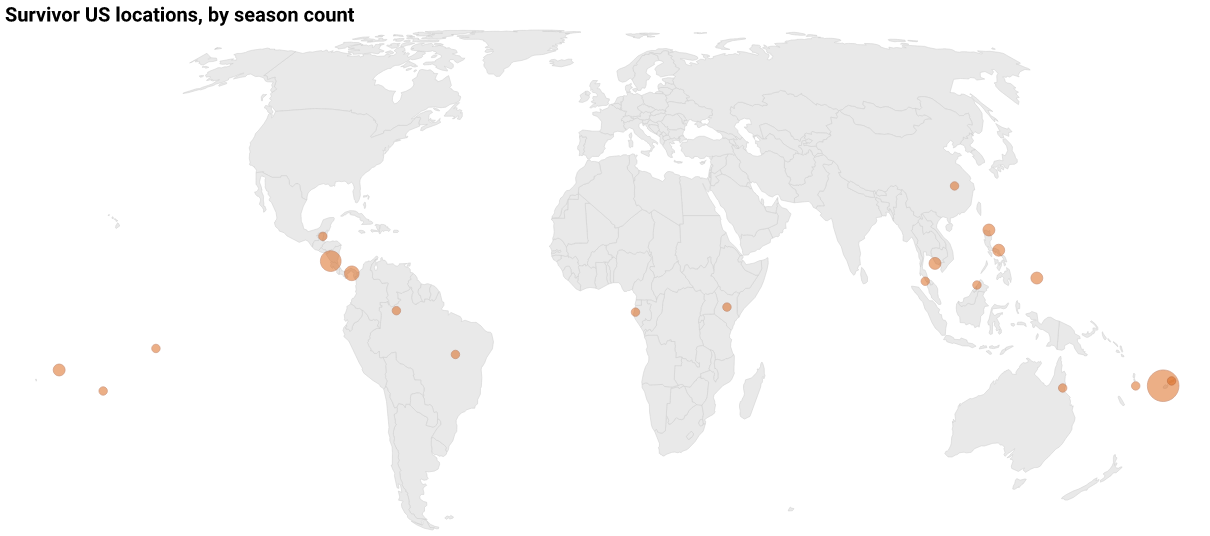

In [9]:
export.save("../visuals/map.png")
Image(filename="../visuals/map.png")